# Computing Lagrangian Coherent Structures on Analytically Defined Flows
By Tanner Harms

In this tutorial we will compute Lagrangian Coherent Structures (LCS) on simple analytically defined flows using a variety of tools from the LCS literature.  The objective of this notebook is to help researchers new to the field gain intuition for the subject matter and familiarity for the various methods employed.  Enjoy!

In [8]:
# General imports that may be useful throughout:
import os, sys, copy
import numpy as np
from matplotlib import pyplot as plt

## Generating Trajectories
Every LCS analysis is driven by the trajectories of tracers embedded on some dynamical system.  Here, we choose (or define) a dynamical system and artificially seed tracers into it.  These tracers represent the observations of the dynamical system which we will use to identify the patterns known as coherent structures.  

Because it is so commonly used in the study of LCS, we will primarily do our analyses on the double gyre flow, which is defined below:
$$\begin{aligned}
    u &= -\pi A \sin\left(\pi f(x,t)\right)\cos(\pi y),\\  
    v &= \pi A \cos\left(\pi f(x,t)\right)\sin(\pi y) \dfrac{\partial f(x,t)}{\partial x},
\end{aligned}$$
where
$$\begin{aligned}
    f(x,t) &= a(t) x^2 + b(t)x, &   a(t) &= \epsilon \sin(\omega t),  & b(t) &= 1-2\epsilon \sin(\omega t),
\end{aligned}$$
I have defined this in the ```./Flows``` folder along with some other utilities to use it.  Let's test it out. 


In [9]:
# Import the functions from the Flows folder
from Flows.Flows import Flow

# Initialize a flow object
function_name = "Gyre"
gyre = Flow()

''' Now, we need to define the initial conditions for our integrations. We will define them on a grid for now.  '''
# Specify the flow domain using dim[0] = x axis and dim[1] = y axis
domain = np.array([[0, 2],[0, 1]])

# Now, make vectors associated with each axis.
n_y = 10            # number of rows
dx = 1/n_y          # row spacing
x_vec = np.arange(domain[0,0],domain[0,1]+dx,dx)     # 50 columns
y_vec = np.arange(domain[1,0],domain[1,1]+dx,dx)     # 25 rows

# Then, make the mesh grid and flatten it to get a single vector of positions.  
mesh = np.meshgrid(x_vec, y_vec)
x = mesh[0].reshape(-1,1)
y = mesh[1].reshape(-1,1)
initial_conditions = np.append(x, y, axis=1)

# Next, we need to make a time vector
t0 = 0      # initial time
t1 = 20      # final time
dt = 0.1    # time increment
time_vector = np.arange(t0,t1+dt,dt)

'''We now need to specify the flow that the Flow object will operate on.'''
parameters = {  # These are specified as defaults as well. 
    "A": 0.1,
    "epsilon": 0.1,
    "omega":2*np.pi/10
}
gyre.predefined_function(function_name, initial_conditions, time_vector, parameters=parameters)

# Integrate the particles over the defined time vector
gyre.integrate_trajectories()
n_particles, n_times, dim = np.shape(gyre.states)


Now, let's visualize the results of this.  We are going to plot the trajectory of every particle that we simulated.

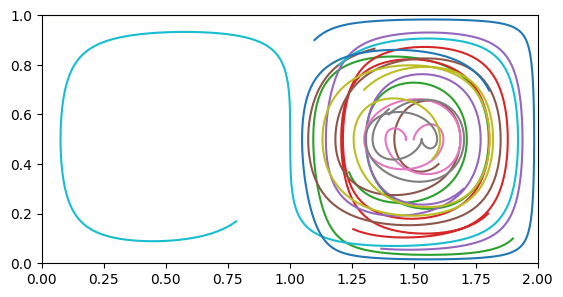

In [10]:
# Create a new figure
fig, ax = plt.subplots(1,1)

# Set the x and y limits to be the same
ax.axis('scaled')
ax.set_xlim([0, 2])
ax.set_ylim([0, 1])

# Loop through each trajectory in self.states and plot it on the same axis
for i in range(0, n_particles, 20):
    x_vals = gyre.states[i,:,0]
    y_vals = gyre.states[i,:,1]
    ax.plot(x_vals, y_vals)

# Show the plot
# plt.show()

We can also animate the results

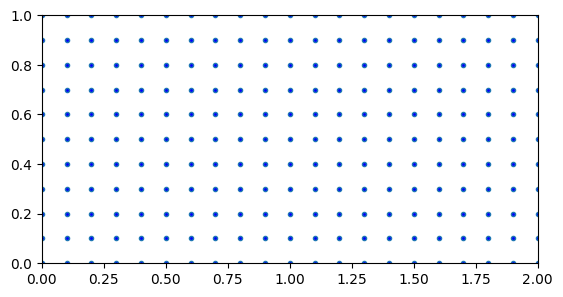

In [11]:
import matplotlib.animation as animation
import matplotlib as mpl
mpl.rcParams['animation.embed_limit'] = 100 # Mb

# Create a new figure
fig, ax = plt.subplots(1,1)

# Set the x and y limits to be the same
ax.axis('scaled')
ax.set_xlim([0, 2])
ax.set_ylim([0, 1])

# initialize the plot
l, = ax.plot([],[],'o', markerfacecolor='blue', markersize=3)

# Loop through each trajectory in self.states and plot it on the same axis
def update(frame):
    x_vals = gyre.states[:,frame,0]
    y_vals = gyre.states[:,frame,1]
    l.set_data(x_vals, y_vals)

ani = animation.FuncAnimation(fig, update, frames=n_times, interval=dt*1000)
from IPython.display import HTML
HTML(ani.to_jshtml())


## Computing Geometric LCS
Great.  Now that we have visualized the flow, let's compute some LCS.  First, though, we should make a denser grid of particles. 

In [21]:
# Reinitialize the flow object using Gyre once again
gyre = Flow()

# Now, make a denser grid of particles
n_y = 20               # number of rows
dx = 1/n_y              # row spacing
x_vec = np.arange(domain[0,0],domain[0,1]+dx,dx)     # 50 columns
y_vec = np.arange(domain[1,0],domain[1,1]+dx,dx)     # 25 rows

# Then, make the mesh grid and flatten it to get a single vector of positions.  
mesh = np.meshgrid(x_vec, y_vec)
x = mesh[0].reshape(-1,1)
y = mesh[1].reshape(-1,1)
initial_conditions = np.append(x, y, axis=1)

# Next, we need to make a time vector
t0 = 0      # initial time
t1 = 12      # final time
dt = 0.1    # time increment <- # For standard FTLE we will only need the first and last time, but 
                                # it will be helpful when computing LAVD to have increments.
time_vector = np.arange(t0,t1+dt,dt)

'''We now need to specify the flow that the Flow object will operate on.'''
# parameters = {  # These are specified as defaults as well. 
#     "A": 0.1,
#     "epsilon":0.1,
#     "omega":2*np.pi/10
# }
gyre.predefined_function(function_name, initial_conditions, time_vector,
                         parameters=parameters, include_gradv=True)  # <- including gradv for LAVD

### Finite-Time Lyapunov Exponent (FTLE) and Lagrangian-Averaged Voriticty Deviation (LAVD)
We shall now compute the finite-time Lyapunov exponents.  These were the original LCS metric (See Haller and Yuan 2000), and indicate the rate of stretching for a linear deformation from time 0 to time 1.  Here we will to calculate them the traditional way using numerical gradients.  Additionally we will compute the LAVD for this flow, which indicates the amount of rotation that a fluid element undergoes during a time interval.  Specifically, it is the Lagrangian (that is, along a particle) average of the magnitude of the vorticity over a time domain.  The result represents twice the intrinsic rotation angle, which represents the angle of rotation a particle experiences with respect to its own frame of reference.  

In [22]:
import GeometricLCS.Geometric as geom

# First, integrate the trajectories.
print("Integrating Trajectories...")
gyre.integrate_trajectories()


Integrating Trajectories...


Computing Jacobians...
(21, 41, 2, 2)
Computing FTLE...
Computing LAVD...


C:\Users\harms\AppData\Local\Temp\ipykernel_32604\526034135.py:36: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


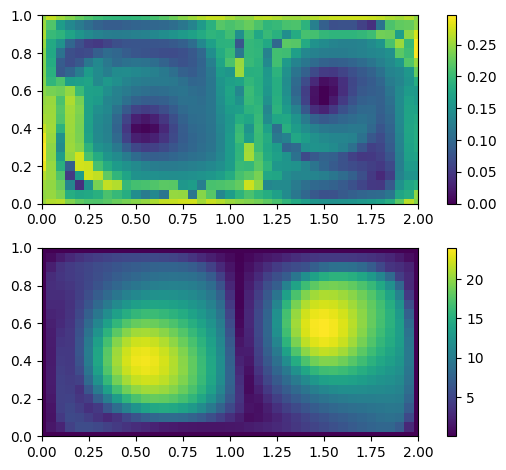

In [23]:

# Computing the jacobian at each mesh position
print("Computing Jacobians...")
J_array = geom.computeJacobian(gyre.states, mesh)

# J_array stores a d-by-d array at each particle mesh location.
print(np.shape(J_array))

# Computing the FTLE field.
print("Computing FTLE...")
ftle_field = geom.computeFTLE(J_array, t1-t0)

# Computing the LAVD field.
print("Computing LAVD...")
lavd_field = geom.computeLAVD(gyre.states, gyre.time_vector, mesh, gyre.gradv_function)

# Creating a figure
ftle_min = 0
ftle_max = np.max(ftle_field)
fig, ax = plt.subplots(2,1)
ax[0].axis('scaled')
ax[0].set_xlim([0,2])
ax[0].set_ylim([0,1])
h0 = ax[0].pcolormesh(mesh[0], mesh[1], ftle_field)
im_ratio = mesh[0].shape[0]/mesh[0].shape[1]
cbar0 = fig.colorbar(h0, fraction=0.046*im_ratio)
cbar0.mappable.set_clim(ftle_min, ftle_max)

ax[1].axis('scaled')
ax[1].set_xlim([0,2])
ax[1].set_ylim([0,1])
h1 = ax[1].pcolormesh(mesh[0], mesh[1], lavd_field)
im_ratio = mesh[0].shape[0]/mesh[0].shape[1]
cbar1 = fig.colorbar(h1, fraction=0.046*im_ratio)

fig.tight_layout()
fig.show()
